In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [107]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['Transported'] = np.nan
data = pd.concat([train, test], axis = 0)
temp = data.copy()

In [24]:
data.Age.replace(np.nan, data.Age.median(), inplace = True)

data[['group', 'number']] = data.PassengerId.str.split('_', expand = True)
data.drop(['PassengerId', 'number', 'Name'], inplace = True, axis = 1)
data.groupby
data.HomePlanet.bfill(inplace = True)
data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,group
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0001
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1.0,0002
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0.0,0003
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0.0,0003
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1.0,0004


In [25]:
def fill_cryosleep(group):
    group = group.copy()
    if group['CryoSleep'].isnull().all():
        random_choice = np.random.choice(data['CryoSleep'].dropna())
        group['CryoSleep'] = [random_choice] * len(group)
    else:
        group['CryoSleep'] = group['CryoSleep'].ffill().bfill()
    return group

data = data.groupby('group').apply(fill_cryosleep).reset_index(drop = True)

In [26]:
def fill_homeplanet(group):
    group = group.copy()
    if group.HomePlanet.isnull().all():
        group.HomePlanet = group.HomePlanet.bfill()
    else:
        group['HomePlanet'] = group['HomePlanet'].ffill().bfill()
    return group
        
data = data.groupby('group').apply(fill_homeplanet).reset_index(drop = True)

In [27]:
data.isnull().sum()

HomePlanet         0
CryoSleep          0
Cabin            299
Destination      274
Age                0
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Transported     4277
group              0
dtype: int64

In [28]:
data.loc[(data.HomePlanet == 'Earth') & (data.VIP.isnull()), 'VIP'] = data.loc[(data.HomePlanet == 'Earth') & (data.VIP.isnull()), 'VIP'].replace(np.nan, False)

data.loc[data['VIP'].isnull(), 'VIP'] = data[data['VIP'].isnull()].apply(
    lambda row: True if row['CryoSleep'] == 'False' and row['Age'] >= 28 else False, axis=1)

In [29]:
def fill_cabin(group):
    group = group.copy()
    if group['Cabin'].isnull().all():
        random_cabin = np.random.choice(data['Cabin'].dropna())
        group['Cabin'] = [random_cabin] * len(group)
    else:
        group['Cabin'] = group['Cabin'].ffill().bfill()
    return group
    
data = data.groupby('group').apply(fill_cabin).reset_index(drop=True)

In [30]:
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in cols:
    data.loc[(data.CryoSleep == True) & data[col].isnull(), col] = data.loc[(data.CryoSleep == True) & data[col].isnull(), col].fillna('0.0').astype('float64')

for col in cols:
    data[col] = data.groupby(['HomePlanet','VIP'])[col].fillna(data[col].mean())

data.drop('group', axis = 1, inplace = True)

In [31]:
data[['deck', 'num', 'side']] = data.Cabin.str.split('/', expand = True)
data.drop(['Cabin', 'num'], inplace = True, axis = 1)

data[['CryoSleep', 'VIP']] = data[['CryoSleep', 'VIP']].astype(int)

In [32]:
dummydeck = pd.get_dummies(data[['HomePlanet', 'Destination', 'deck', 'side']]) * 1
data = pd.concat([data, dummydeck], axis = 1)
data.drop(['HomePlanet', 'Destination', 'deck', 'side'], axis = 1, inplace = True)

In [33]:
data['totalspending'] = data.RoomService + data.FoodCourt + data.ShoppingMall + data.VRDeck + data.Spa

In [34]:
data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S,totalspending
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,1,0,0,0,0,0,0,1,0,0.0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1.0,1,...,0,0,0,0,1,0,0,0,1,736.0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0.0,0,...,0,0,0,0,0,0,0,0,1,10383.0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0.0,0,...,0,0,0,0,0,0,0,0,1,5176.0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1.0,1,...,0,0,0,0,1,0,0,0,1,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1,43.0,0,0.0,0.0,0.0,0.0,0.0,NaN,1,...,0,0,0,0,0,1,0,0,1,0.0
12966,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,0,1,0,0,1,0.0
12967,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1.0,1,...,0,0,0,0,0,1,0,0,1,1873.0
12968,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0.0,0,...,0,0,0,1,0,0,0,0,1,4637.0


In [35]:
data = data[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'totalspending', 'CryoSleep', 'VIP', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'deck_A',
       'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T',
       'side_P', 'side_S', 'Transported']]

In [36]:
data.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,totalspending,CryoSleep,VIP,HomePlanet_Earth,...,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S,Transported
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,1,0,0,0,0,0,0,1,0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,736.0,0,0,1,...,0,0,0,0,1,0,0,0,1,1.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,10383.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,5176.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1091.0,0,0,1,...,0,0,0,0,1,0,0,0,1,1.0


In [88]:
X_train = data.loc[data.Transported.notnull()]
y_train = X_train.pop('Transported')
y_train = y_train.astype(int)
test = data.loc[data.Transported.isnull()]
test.drop('Transported', axis = 1, inplace = True)

/tmp/ipykernel_5840/2730761303.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('Transported', axis = 1, inplace = True)


In [89]:
scaler = StandardScaler()
X_train.iloc[:, :7] = scaler.fit_transform(X_train.iloc[:, :7])
test.iloc[:, :7] = scaler.transform(test.iloc[:, :7])

In [90]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, verbose = 1)

In [91]:
modeln = Sequential([
    Dense(16, activation = 'gelu'),
    Dense(8, activation = 'gelu'),
    Dense(4, activation = 'gelu'),
    Dense(1, activation = 'sigmoid')
])
modeln.compile(loss = 'BinaryCrossentropy', optimizer = Adam(learning_rate = 0.0001))
history = modeln.fit(x = X_train, y = y_train, epochs = 150)

Epoch 1/150
272/272 [==============================] - 0s 565us/step - loss: 0.6730
Epoch 2/150
272/272 [==============================] - 0s 532us/step - loss: 0.6382
Epoch 3/150
272/272 [==============================] - 0s 531us/step - loss: 0.5942
Epoch 4/150
272/272 [==============================] - 0s 527us/step - loss: 0.5452
Epoch 5/150
272/272 [==============================] - 0s 527us/step - loss: 0.5028
Epoch 6/150
272/272 [==============================] - 0s 528us/step - loss: 0.4741
Epoch 7/150
272/272 [==============================] - 0s 534us/step - loss: 0.4579
Epoch 8/150
272/272 [==============================] - 0s 536us/step - loss: 0.4489
Epoch 9/150
272/272 [==============================] - 0s 514us/step - loss: 0.4432
Epoch 10/150
272/272 [==============================] - 0s 511us/step - loss: 0.4391
Epoch 11/150
272/272 [==============================] - 0s 539us/step - loss: 0.4358
Epoch 12/150
272/272 [==============================] - 0s 534us/step - lo

<Axes: >

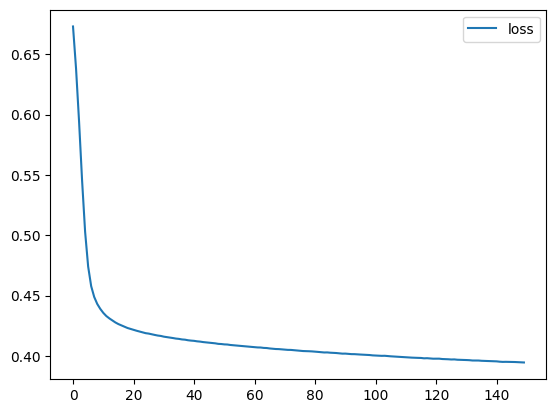

In [92]:
sns.lineplot(history.history)

In [93]:
pred = modeln.predict(test)

134/134 [==============================] - 0s 388us/step


In [103]:
pred = np.where(pred >= 0.5, 1, 0)
ans = pd.Series(pred, name = 'Transported').astype('bool')

0        True
1       False
2        True
3        True
4        True
        ...  
4272     True
4273    False
4274     True
4275     True
4276     True
Name: Transported, Length: 4277, dtype: bool

In [108]:
ans = pd.Series(pred, name = 'Transported').astype('bool')
passid = pd.Series(temp[temp.Transported.isnull()].PassengerId, name = 'PassengerId')

In [110]:
ans = pd.concat([passid, ans], axis = 1)

In [111]:
ans

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [112]:
ans.to_csv('ans.csv', index = False)